In [1]:
from datetime import datetime
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
BASE_DATA_PATH = os.path.join("out")
OUTPUT_FOLDER = os.path.join("out", "plots")

def get_dataset_file(cloud_name, timestamp = "latest", data_path = BASE_DATA_PATH):
    # Get all CSV files in the folder
    csv_folder = os.path.join(data_path, cloud_name)
    csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
    df = None
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {csv_folder}")
    if timestamp == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),
            "%Y-%m-%d-%H:%M:%S"
        ))
        print(f"Loading latest file: {file}")
        df = pd.read_csv(file)
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            file_timestamp = filename.split('-')[1:]  # Split to get timestamp part
            file_timestamp = '-'.join(file_timestamp).replace('.csv', '')  # Rebuild timestamp string
            if timestamp == file_timestamp:
                print(f"Loading file: {file}")
                df = pd.read_csv(file)
        if df is None:
               FileNotFoundError(f"File with date '{timestamp}' not found in folder: {csv_folder}")
    # Convert times to milliseconds
    df['mean'] = df['mean'] * 1000
    df['stdev'] = df['stdev'] * 1000#
    df['warmup_time'] = df['warmup_time'] * 1000
    return df

def read_multiple_datasets(clouds_datasets, data_path = BASE_DATA_PATH):
    dfs = {}
    for cloud, dataset in clouds_datasets.items():
        dfs[cloud] = get_dataset_file(cloud, "latest", data_path)
    return dfs

def output_fig(fig, filename, dataset = "all", cloud = None):
    output_folder = ""
    if cloud is None:
        output_folder = os.path.join(OUTPUT_FOLDER, dataset)
    else:
        output_folder = os.path.join(OUTPUT_FOLDER, dataset, cloud)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    fig.savefig(os.path.join(output_folder, filename), dpi=300, bbox_inches='tight')
    plt.close(fig)

In [2]:
plt.rcParams.update({
    'font.family': 'sans-serif',  # Use sans-serif as a fallback
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    
    'font.size': 10,
    'axes.labelsize': 9,
    'axes.titlesize': 11,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 12,
    
    'axes.grid': True,
    'axes.grid.axis': 'y',  # Only horizontal grid lines
    'grid.linestyle': '-',  # Solid line
    'grid.linewidth': 0.4,  # Very thin grid lines
    'grid.color': '#CCCCCC',  # Light gray grid
    
    'axes.axisbelow': True,
    'figure.figsize': (6, 4),  # Standard publication-friendly figure size
    'figure.dpi': 100, # Smaller preview
    # 'figure.dpi': 300, 
    
    'lines.linewidth': 1.0,  # Consistent line thickness
    'lines.markersize': 4,  # Consistent marker size

    'figure.facecolor': 'white',  # Background color of the figure
    'figure.edgecolor': 'white',   # Edge color of the figure
})

In [3]:
# Some aux. functions for plot information
def add_execution_details(cloud, dataset, searches, repeats, points, fig, h_ex=0.93):
    execution_details = [
        f"- {searches:,} searches x {repeats:,} repeats",
        f"- Point cloud: {cloud} ({points:,} points)",
        f"- Dataset: {dataset}",
    ]
    fig.text(0.10, h_ex,
            '\n'.join(execution_details),
            fontfamily='monospace',
            color='#505050',
            ha='left',
            va='top',
            linespacing=1.3)
    
def add_execution_details_multiple_datasets(clouds, searches, repeats, fig, h_ex=0.90):
    execution_details = [
        f"- {searches:,} searches x {repeats:,} repeats",
        f"- {len(clouds)} point clouds",
    ]
    fig.text(0.10, h_ex,
            '\n'.join(execution_details),
            fontfamily='monospace',
            color='#505050',
            ha='left',
            va='top',
            linespacing=1.3)

def add_title_subtitle(title, subtitle, fig, h_title=0.98, h_subtitle=0.95):
    fig.text(0.10, h_title, 
            title, 
            fontsize=16, 
            fontweight='bold', 
            ha='left', 
            va='top')

    fig.text(0.10, h_subtitle,
            subtitle,
            fontsize=12,
            fontstyle='italic',
            color='#404040',
            ha='left',
            va='top')

def add_octree_types_legend(legend_handles, legend_labels, legend_title, fig):
    fig.legend(
        legend_handles,
        legend_labels,
        title=legend_title,
        loc="upper right",
        bbox_to_anchor=(0.9, 1)
    )

In [4]:
# This dicts store information about the type parameters and possible combinations used in each visualization, 
# along with the palette of colors
TYPES_INFO_OCTREE_ENCODER = {
    "type_parameters":  ['octree', 'encoder'],
    "available_types": pd.DataFrame({
        'octree': ['LinearOctree', 'LinearOctree', 'Octree', 'Octree', 'Octree'],
        'encoder': ['HilbertEncoder3D', 'MortonEncoder3D', 'HilbertEncoder3D', 'MortonEncoder3D', 'Unencoded']
    }),

    "palette": {
        ('LinearOctree', 'HilbertEncoder3D'): '#1984c5',
        ('LinearOctree', 'MortonEncoder3D'): '#63bff0',
        ('Octree', 'HilbertEncoder3D'): '#c23728',
        ('Octree', 'MortonEncoder3D'): '#de6e56',
        ('Octree', 'Unencoded'): '#e1a692'
    }
}

TYPES_INFO_OCTREE_POINT = {
    "type_parameters":  ['octree', 'point_type'],
    "available_types": pd.DataFrame({
        'octree': ['LinearOctree', 'LinearOctree', 'LinearOctree', 'Octree', 'Octree', 'Octree'],
        'point_type': ['Point', 'Lpoint64', 'Lpoint', 'Point', 'Lpoint64', 'Lpoint']
    }),
    "palette": {
        ('LinearOctree', 'Point'): '#0f5f87',
        ('LinearOctree', 'Lpoint64'): '#1984c5',
        ('LinearOctree', 'Lpoint'): '#63bff0',
        ('Octree', 'Point'): '#9f1b17',
        ('Octree', 'Lpoint64'): '#de6e56',
        ('Octree', 'Lpoint'): '#e1a692'
    }
}

In [5]:
OCTREE_COMP_DATA_PATH = os.path.join(BASE_DATA_PATH, "octree_comp")
ALGO_COMP_DATA_PATH = os.path.join(BASE_DATA_PATH, "algo_comp")
POINT_COMP_DATA_PATH = os.path.join(BASE_DATA_PATH, "point_comp")
APPROX_SEARCH_DATA_PATH = os.path.join(BASE_DATA_PATH, "approx_search")

In [ ]:
def octree_runtime_comparison(cloud, dataset, operations, operation_name, show_warmup_time=False, types_info=TYPES_INFO_OCTREE_ENCODER, data_path=OCTREE_COMP_DATA_PATH):
    df = get_dataset_file(cloud, "latest", data_path)
    # Filter the dataset for the specified operation
    operation_df = df[df['operation'].isin(operations)]
    # Get unique radii and kernels
    radii = sorted(operation_df['radius'].unique())
    kernels = operation_df['kernel'].unique()
   
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)),
                              gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
   
    # Bar spacing parameters
    bar_width = 0.15
    group_width = bar_width * len(types_info["available_types"])
    group_gap = 0.5
   
    legend_handles, legend_labels = [], []
    # First loop through each radius: 1.0, 2.5, 5.0, ...
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = operation_df[operation_df['radius'] == radius]
        # Now iterate through kernels: circle, sphere, square, cube, ...
        kernel_labels = []
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            if kernel_data.empty:
                kernel_labels.append(f'{kernel} kernel\nNo data available')
                continue
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f'{kernel} kernel\nAvg. points found: {avg_total:,.0f}')
           
            # Finally, iterate through each of the octree implementations identified by the (octree, encoder, point_type) tuple
            for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
                # Extract parameters dynamically from the row
                key = tuple(params[col] for col in types_info["type_parameters"])
                octree_data = kernel_data[
                    (kernel_data[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
                ]
                if octree_data.empty:
                    continue
                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                warmup_times = octree_data['warmup_time'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                
                # Main execution time bar
                bar = ax.bar(x_pos, means[0], bar_width,
                             color=types_info["palette"][key])
                
                # Warmup time bar (if enabled)
                if show_warmup_time:
                    ax.bar(x_pos, warmup_times[0], bar_width, 
                           color="none", 
                           edgecolor='black', alpha = 0.5,
                           zorder=-2)  # Ensure it's drawn on top
                
                ax.errorbar(x_pos, means[0], stdevs[0],
                            color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
               
                formatted_label = ", ".join(f"{value}" for param, value in zip(types_info["type_parameters"], key))
                if radius_idx == 0 and formatted_label not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)
        
        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
       
        ax.text(0.04, 0.96, f'Radius = {radius}',
                transform=ax.transAxes,
                fontsize=12, fontweight='bold',
                va='top', ha='left')
       
        ax.set_ylabel('Execution time (ms)')
   
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)
    add_title_subtitle(f"{operation_name} performance analysis", 
                       f"Analysis of octree type over multiple search radii and kernels{' with warmup times' if show_warmup_time else ''}", 
                       fig)
    # The number of searches, repeats and points in the dataframe are in every row of the csv
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    npoints = df['npoints'].iloc[0]
    add_execution_details(cloud, dataset, nsearches, nrepeats, npoints, fig)
    return fig

In [ ]:
# Plot comparison of neighSearch runtimes for Lille_0 across all radii kernels benchmarked and all octree types
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", ['neighSearchStruct', 'neighSearch'], 'Neighbor search')

In [ ]:
# Plot comparison of neighSearch runtimes for Lille_0 across all radii kernels benchmarked and all octree types
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", ['numNeighSearch'], 'Neighbor search')

In [ ]:
# Same plots but with warmup times
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", ['neighSearchStruct', 'neighSearch'], 'Num. of neighbors search', True)

In [ ]:
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", ['numNeighSearch'], 'Num. of neighbors search', True)

In [ ]:
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", ['neighSearchStruct', 'neighSearch'], 'Num. of neighbors search', True, TYPES_INFO_OCTREE_POINT, POINT_COMP_DATA_PATH)

In [ ]:
def octree_operations_comparison(cloud, dataset, operations, palette, data_path=ALGO_COMP_DATA_PATH):
    df = get_dataset_file(cloud, "latest", data_path)
    # Filter for the specified operations
    df = df[df['operation'].isin(operations)]
    
    # Get unique radii and kernels
    radii = sorted(df['radius'].unique())
    kernels = df['kernel'].unique()
    
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)),
                           gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
    
    # Bar spacing parameters
    bar_width = 0.35 / len(operations)  # Dynamically adjust width based on operation count
    group_width = bar_width * len(operations)
    group_gap = 0.10
    
    legend_handles, legend_labels = [], []
    
    # First loop through each radius
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = df[df['radius'] == radius]
        
        # Now iterate through kernels
        kernel_labels = []
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            if kernel_data.empty:
                kernel_labels.append(f'{kernel} kernel\nNo data available')
                continue
            
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f'{kernel} kernel\nAvg. points found: {avg_total:,.0f}')
            
            for j, operation in enumerate(operations):
                op_data = kernel_data[kernel_data["operation"] == operation]
                if op_data.empty:
                    print(f"Warning: No data found for operation {operation} in radius {radius} and kernel {kernel}")
                    continue
                
                means = op_data['mean'].values
                stdevs = op_data['stdev'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                
                # Get color from palette, with fallback for extra operations
                color_idx = j % len(palette)
                bar = ax.bar(x_pos, means[0], bar_width,
                            color=palette[color_idx])
                ax.errorbar(x_pos, means[0], stdevs[0],
                           color='gray', capsize=3, capthick=1,
                           fmt='none', elinewidth=1)
                
                if radius_idx == 0 and operation not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append(operation)
        
        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 - bar_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
        
        ax.text(0.04, 0.96, f'Radius = {radius}',
               transform=ax.transAxes,
               fontsize=12, fontweight='bold',
               va='top', ha='left')
        
        ax.set_ylabel('Execution time (ms)')
    
    # Create a descriptive title for multiple operations
    title = " vs ".join(operations)
    subtitle = "Performance comparison between different Linear Octree search algorithms"
    
    add_octree_types_legend(legend_handles, legend_labels, "Operation performed", fig)
    add_title_subtitle(title, subtitle, fig)
    
    # The number of searches, repeats and points in the dataframe are in every row of the csv
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    npoints = df['npoints'].iloc[0]
    add_execution_details(cloud, dataset, nsearches, nrepeats, npoints, fig)
    
    return fig

In [ ]:
search_impl_palette = ["#1984c5", "#22a7f0", "#e14b31"]
fig = octree_operations_comparison("Lille_0", "Paris_Lille", ['neighSearchStruct', 'neighSearch', 'neighOldSearch'], search_impl_palette)

In [ ]:
num_search_impl_palette = ["#1984c5", "#e14b31"]
fig = octree_operations_comparison("Lille_0", "Paris_Lille", ['numNeighSearch', 'numNeighOldSearch'], num_search_impl_palette)

In [ ]:
# Test shuffled vs sequential search sets (OLD IDEA)
seq_vs_shuffled_path = os.path.join("out_old", "seq_vs_shuffle")
seq_vs_shuffled_palette = ["#1984c5", "#e14b31"]
fig = octree_operations_comparison("Lille_0", "Paris_Lille", ['neighSearch_shuffled', 'neighSearch_sequential'], seq_vs_shuffled_palette, seq_vs_shuffled_path)

In [ ]:
def approximate_search_comparison(cloud, dataset, kernel="Sphere", data_path=APPROX_SEARCH_DATA_PATH):
    # Load data
    df = get_dataset_file(cloud, "latest", data_path)
    # Define operations and their colors
    operations = ['neighSearchStruct', 'neighSearchApproxUpper', 'neighSearchApproxLower']
    operations_palette = {
        'neighSearchStruct': "#3ca370",
        'neighSearchApproxUpper': '#1984c5',
        'neighSearchApproxLower': '#e14b31'
    }
    
    # Filter for the specified operations
    df = df[df['operation'].isin(operations)]
    # Filter by kernel too
    df = df[df['kernel'] == kernel]
    # Get unique radii
    radii = sorted(df['radius'].unique())
    
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)),
                           gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
    
    legend_handles, legend_labels = [], []
    
    # Process each radius
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        
        # Get data for this radius
        radius_data = df[df['radius'] == radius].copy()
        
        # Find baseline (exact search)
        baseline_row = radius_data[(radius_data['operation'] == 'neighSearchStruct') & 
                                 (radius_data['tolerance_percentage'] == 0)]
        if baseline_row.empty:
            ax.text(0.5, 0.5, f'No exact search data available for radius {radius}',
                  transform=ax.transAxes, ha='center', va='center')
            continue
        
        baseline = baseline_row['avg_result_size'].iloc[0]
        
        # Compute relative points
        radius_data['relative_points'] = (radius_data['avg_result_size'] / baseline) * 100
        
        # Remove approximate searches that equal the exact search
        # approx_mask = (radius_data['operation'] != 'neighSearchStruct') & (radius_data['relative_points'] == 100)
        # radius_data = radius_data[~approx_mask]
        
        # Connect points with gray line for each operation within this radius
        for op in operations:
            op_data = radius_data[radius_data['operation'] == op].sort_values('relative_points')
            if not op_data.empty:
                ax.plot(op_data['relative_points'], op_data['mean'],
                      color='gray', alpha=0.5, linestyle='-')
                
                # Plot the scatter points
                scatter = ax.scatter(op_data['relative_points'], op_data['mean'],
                                  color=operations_palette[op], s=80)
                
                # Add to legend only once
                if radius_idx == 0 and op not in legend_labels:
                    legend_handles.append(scatter)
                    legend_labels.append(op)
                
                # Annotate points with tolerance percentage
                for _, row in op_data.iterrows():
                    ax.annotate(f"{row['tolerance_percentage']}% tol", 
                              (row['relative_points'], row['mean']),
                              xytext=(5, 5), textcoords='offset points',
                              fontsize=8)
        
        ax.text(0.04, 0.96, f'Radius = {radius}',
               transform=ax.transAxes,
               fontsize=12, fontweight='bold',
               va='top', ha='left')
        
        y_max = radius_data['mean'].max()
        ax.set_ylim(0, y_max * 1.1)  # Increase by 10% the Y limit

        ax.set_xlabel("Points Found (% of exact search)")
        ax.set_ylabel("Execution time (ms)")
        ax.grid(True, alpha=0.3)
        ax.grid(True, alpha=0.3)
    
    # Add overall title and subtitle
    add_octree_types_legend(legend_handles, legend_labels, "Search method", fig)
    add_title_subtitle("Approximate Search Performance Analysis",
                      f"Execution time vs. percentage of points found, {kernel} kernel", fig)
    
    # Add execution details if available
    if not df.empty:
        nsearches = df['num_searches'].iloc[0]
        nrepeats = df['repeats'].iloc[0]
        npoints = df['npoints'].iloc[0]
        add_execution_details(cloud, dataset, nsearches, nrepeats, npoints, fig)
    
    return fig

In [ ]:
approx_data_path = os.path.join(BASE_DATA_PATH, "approx_search")
fig = approximate_search_comparison("Lille_0", "Paris_Lille", "Cube")

In [ ]:
# Multiple datasets
CLOUDS_DATASETS = {"Lille_0": "Paris_Lille", 
                    "Lille_11": "Paris_Lille",
                    "Paris_Luxembourg_6": "Paris_Lille",
                    "5110_54320": "Dales_LAS",
                    "5135_54435": "Dales_LAS"
                }
RADII = {0.5, 1.0, 2.5, 5.0}
CLOUDS_DATASETS_HIGH_DENSITY = {
                    "bildstein_station1_xyz_intensity_rgb": "Semantic3D",
                    "sg27_station8_intensity_rgb": "Semantic3D",
                    "Speulderbos_2017_TLS": "Speulderbos"
                }
RADII_HIGH_DENSITY = {0.05, 0.1, 0.25, 0.5}

In [ ]:
# Idea 3.
def multiple_dfs_runtimes(clouds_datasets, kernel, radii, operations, operation_name, types_info=TYPES_INFO_OCTREE_ENCODER):
    dfs = read_multiple_datasets(clouds_datasets, OCTREE_COMP_DATA_PATH)
    fig, axes = plt.subplots(len(radii), len(dfs), 
                              figsize=(max(15, len(dfs) * 2.5), len(radii) * 2.5),
                              gridspec_kw={'wspace': 0.7, 'hspace': 0.2})

    # Ensure axes are iterable for single-row or single-column cases
    if len(radii) == 1:
        axes = [axes]
    if len(dfs) == 1:
        axes = [[ax] for ax in axes]

    # Define bar width and spacing
    bar_width = 0.02

    legend_handles, legend_labels = [], []

    # Iterate over radii and datasets
    for radius_idx, radius in enumerate(radii):
        for df_idx, (df_name, df) in enumerate(dfs.items()):
            ax = axes[radius_idx][df_idx]

            # Filter data for the current kernel, radius, and operation
            radius_data = df[(df['kernel'] == kernel) & (df['radius'] == radius) & (df['operation'].isin(operations))]

            if radius_data.empty:
                ax.text(0.5, 0.5, f"No data available\n{df_name}\nRadius = {radius}",
                        transform=ax.transAxes, ha='center', va='center', fontsize=8, color='red')
                ax.axis('off')
                continue
            
            # Iterate through octree implementations
            for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
                key = tuple(params[col] for col in types_info["type_parameters"])
                octree_data = radius_data[
                    (radius_data[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
                ]

                if octree_data.empty:
                    continue

                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                x_pos = j * bar_width
                bar = ax.bar(x_pos, means[0], bar_width, color=types_info["palette"][key])
                ax.errorbar(x_pos, means[0], stdevs[0],
                            color='gray', capsize=2, capthick=1,
                            fmt='none', elinewidth=1)

                formatted_label = ", ".join(f"{value}" for param, value in zip(types_info["type_parameters"], key))
                if (radius_idx == 0) and (df_idx == 0) and (formatted_label not in legend_labels):
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)
                ax.text(0.04, 0.96, f'r = {radius}', 
                    transform=ax.transAxes,
                    fontsize=9, va='top', ha='left')
            # Remove x-ticks
            ax.set_xticks([])
            ax.set_ylabel('Executime time (ms)', fontsize=10)

            avg_total = radius_data['avg_result_size'].iloc[0]
            ax.text(0.5, -0.1, f"Avg. points = {avg_total:,.0f}", 
                    transform=ax.transAxes, ha='center', va='center', fontsize=8)
            
    # Adjust subplot spacing
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    # Add legend and titles
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)

    add_title_subtitle(
        f"{operation_name} performance analysis",
        f"Performance across multiple datasets for {operation_name} using {kernel} kernel\n",
        fig
    )

    # Assuming the first dataframe has consistent metadata
    nsearches = dfs[next(iter(dfs))]['num_searches'].iloc[0]
    nrepeats = dfs[next(iter(dfs))]['repeats'].iloc[0]
    add_execution_details_multiple_datasets(dfs.keys(), nsearches, nrepeats, fig, h_ex=0.93)

    return fig

In [ ]:
fig = multiple_dfs_runtimes(
    CLOUDS_DATASETS, 
    kernel="Sphere", 
    radii=RADII, 
    operations=['neighSearchStruct', 'neighSearch'], 
    operation_name='Neighbor Search'
)

In [ ]:
fig = multiple_dfs_runtimes(
    CLOUDS_DATASETS_HIGH_DENSITY, 
    kernel="Sphere", 
    radii=RADII_HIGH_DENSITY, 
    operations=['neighSearchStruct', 'neighSearch'], 
    operation_name='Neighbor Search'
)

In [ ]:
import math
import numpy as np

def multiple_dfs_speedups(clouds_datasets, kernel, radii, operations, operation_name, types_info=TYPES_INFO_OCTREE_ENCODER):
    dfs = read_multiple_datasets(clouds_datasets, OCTREE_COMP_DATA_PATH)
    fig, axes = plt.subplots(len(radii), len(dfs), 
                              figsize=(max(12, len(dfs) * 3), len(radii) * 2.5 + 2),
                              gridspec_kw={'wspace': 0.7, 'hspace': 0.2})

    # Ensure axes are iterable for single-row or single-column cases
    if len(radii) == 1:
        axes = [axes]
    if len(dfs) == 1:
        axes = [[ax] for ax in axes]

    # Define bar width and spacing
    bar_width = 0.02

    legend_handles, legend_labels = [], []

    # Iterate over radii and datasets
    for radius_idx, radius in enumerate(radii):
        for df_idx, (df_name, df) in enumerate(dfs.items()):
            ax = axes[radius_idx][df_idx]

            # Add the dataset name as the column header on the first row
            if radius_idx == 0:
                ax.set_title(df_name, fontsize=10)

            # Filter data for the current kernel, radius, and operation
            radius_data = df[(df['kernel'] == kernel) & 
                             (df['radius'] == radius) & 
                             (df['operation'].isin(operations))]
            if radius_data.empty:
                ax.text(0.5, 0.5, f"No data\n{df_name}\nRadius = {radius}",
                        transform=ax.transAxes, ha='center', va='center', fontsize=8, color='red')
                ax.axis('off')
                continue

            # Kernel label
            avg_total = radius_data['avg_result_size'].iloc[0]
            
            # Add radius label in top-left of each subplot
            ax.text(0.05, 0.95, f'r = {radius}', 
                    transform=ax.transAxes,
                    fontsize=9, va='top', ha='left')

            # Find base execution time for "Pointer" octree and "Unencoded" encoder
            base_data = radius_data[(radius_data['octree'] == "Octree") & (radius_data['encoder'] == "Unencoded")]
            base_time = base_data['mean'].iloc[0]  # Base execution time for the reference combination

            # Collect speedup values for setting y-axis limits later
            speedups = []

            # Iterate through octree implementations (reversed to show increasing speedups)
            rev_list = list(types_info["available_types"].iterrows())[::-1]
            for j, (_, params) in enumerate(rev_list):
                key = tuple(params[col] for col in types_info["type_parameters"])
                # Skip the baseline (Pointer, Unencoded) combination
                if key == ("Pointer", "Unencoded"):
                    continue
                # Filter for the current octree type
                octree_data = radius_data[
                    (radius_data[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
                ]

                if octree_data.empty:
                    continue

                means = octree_data['mean'].values
                # Calculate the speedup ratio (e.g., 2x means base_time / current_time == 2)
                speedup = base_time / means[0]
                speedups.append(speedup)

                x_pos = j * bar_width
                bar = ax.bar(x_pos, speedup, bar_width, color=types_info["palette"][key])

                formatted_label = ", ".join(f"{value}" for param, value in zip(types_info["type_parameters"], key))
                if (radius_idx == 0) and (df_idx == 0) and (formatted_label not in legend_labels):
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)

            # Set y-axis: start at 1 and set ticks in integer steps formatted as "1x, 2x, 3x, ..."
            if speedups:
                max_speedup = max(speedups + [1])  # Ensure the lower bound is at least 1
                y_max = math.ceil(max_speedup)
                ax.set_ylim(0, y_max)
                ticks = np.arange(0, y_max + 1)
                ax.set_yticks(ticks)
                ax.set_yticklabels([f"{int(t)}x" for t in ticks])
            else:
                # Default axis if no bars were drawn
                ax.set_ylim(0, 2)
                ax.set_yticks([0, 1, 2])
                ax.set_yticklabels(["0x", "1x", "2x"])

            # Remove x-ticks and update y-axis label
            ax.set_xticks([])
            ax.text(0.5, -0.1, f"Avg. points = {avg_total:,.0f}", 
                    transform=ax.transAxes, ha='center', va='center', fontsize=8)

    # Adjust subplot spacing
    plt.subplots_adjust(hspace=0.4, wspace=0.3, bottom=0.15)
    
    # Add legend and titles
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)

    add_title_subtitle(
        f"{operation_name} performance analysis",
        f"Speedup (with respect to baseline Pointer-based octree) using {kernel} kernel",
        fig
    )

    # Assuming the first dataframe has consistent metadata
    nsearches = dfs[next(iter(dfs))]['num_searches'].iloc[0]
    nrepeats = dfs[next(iter(dfs))]['repeats'].iloc[0]
    add_execution_details_multiple_datasets(dfs.keys(), nsearches, nrepeats, fig, 0.93)

    return fig


In [ ]:
fig = multiple_dfs_speedups(
    CLOUDS_DATASETS, 
    kernel="Sphere", 
    radii=RADII, 
    operations=['neighSearchStruct', 'neighSearch'], 
    operation_name='Neighbor Search'
)

In [ ]:
fig = multiple_dfs_speedups(
    CLOUDS_DATASETS_HIGH_DENSITY, 
    kernel="Sphere", 
    radii=RADII_HIGH_DENSITY, 
    operations=['neighSearchStruct', 'neighSearch'], 
    operation_name='Neighbor Search'
)

In [ ]:
# Time to save a lot of plots
ALL_CLOUDS = CLOUDS_DATASETS.copy()
ALL_CLOUDS.update(CLOUDS_DATASETS_HIGH_DENSITY)

In [ ]:
import scipy.stats as stats

def plot_avg_result_sizes_log(clouds_datasets, kernel, operations, operation_name, types_info=TYPES_INFO_OCTREE_ENCODER):
    dfs = read_multiple_datasets(clouds_datasets, OCTREE_COMP_DATA_PATH)
    fig, ax = plt.subplots(figsize=(12, 10))
    legend_handles, legend_labels = [], []
    
    for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
        key = tuple(params[col] for col in types_info["type_parameters"])
        avg_sizes, runtimes = [], []
        
        for df_name, df in dfs.items():
            filtered_df = df[(df['kernel'] == kernel) & (df['operation'].isin(operations))]
            if filtered_df.empty:
                continue
            octree_data = filtered_df[
                (filtered_df[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
            ]
            if octree_data.empty:
                continue
            avg_sizes.extend(octree_data['avg_result_size'].tolist())
            runtimes.extend(octree_data['mean'].tolist())

        if avg_sizes and runtimes:
            scatter = ax.scatter(avg_sizes, runtimes, color=types_info["palette"][key], s=20)
            legend_handles.append(scatter)
            legend_labels.append(", ".join(f"{value}" for param, value in zip(types_info["type_parameters"], key)))
            # linear regression line
            # slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(avg_sizes), np.log(runtimes))
            # regression_line = np.exp(intercept + slope * np.log(np.array(avg_sizes)))
            # ax.plot(avg_sizes, regression_line, color=types_info["palette"][key], linestyle='dashed', linewidth=1)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Average Result Size")
    ax.set_ylabel("Execution Time (ms)")
    
    # Add legend and titles
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)

    add_title_subtitle(
        f"{operation_name} performance analysis",
        f"Average point founds in search vs runtime (log-log plot), using {kernel} kernel",
        fig
    )

    # Assuming the first dataframe has consistent metadata
    nsearches = dfs[next(iter(dfs))]['num_searches'].iloc[0]
    nrepeats = dfs[next(iter(dfs))]['repeats'].iloc[0]
    add_execution_details_multiple_datasets(dfs.keys(), nsearches, nrepeats, fig, 0.93)
    
    return fig


In [ ]:
fig = plot_avg_result_sizes_log(ALL_CLOUDS, "Sphere", ["neighSearchStruct", "neighSearch"], "Neighbors search")

In [ ]:
fig = plot_avg_result_sizes_log(ALL_CLOUDS, "Sphere", ["numNeighSearch"], "Num. of neighbors search")

In [42]:
import seaborn as sns
def octree_parallelization(cloud, dataset, openmp_schedule, octree, data_path):
    df = get_dataset_file(cloud, "latest", data_path)
    df = df[(df["openmp_schedule"] == openmp_schedule) & (df["octree"] == octree)][["num_searches", "repeats", "npoints", "radius", "mean", "openmp_threads"]]
    # Extract ntreads=1 baseline
    baseline = df[df["openmp_threads"] == 1].set_index("radius")["mean"]
    # Merge it on the df
    df = df.merge(baseline.rename("T1"), on="radius")
    # Compute the efficiency as (time 1 thread) / (time n threads * n)
    df["efficiency"] = df["T1"] / (df["openmp_threads"] * df["mean"])
    # Pivot and get the efficiency matrix
    efficiency_matrix = df.pivot(index="radius", columns="openmp_threads", values="efficiency")
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(efficiency_matrix, cmap="mako", annot=True, fmt=".2f", linewidths=0, 
                vmin=0, vmax=1, 
                cbar_kws={'label': 'Efficiency', 'shrink': 0.8}, # Add the shrink parameter
                square=True, ax=ax)    
    plt.subplots_adjust(bottom=0.05)
    # Labels and title
    ax.set_xlabel("Number of Threads")
    ax.set_ylabel("Search radius")
    ax.set_title("Parallel Efficiency Heatmap")

    add_title_subtitle(r"Parallelization Efficiency",
                       f"{'Pointer based Octree' if octree == 'Octree' else 'Linear octree'} with {openmp_schedule} schedule", 
                       fig, 0.9, 0.85)
    # The number of searches, repeats and points in the dataframe are in every row of the csv
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    npoints = df['npoints'].iloc[0]
    add_execution_details(cloud, dataset, nsearches, nrepeats, npoints, fig, 0.8)

    return fig

Loading latest file: out/parallel/Lille_0/Lille_0-2025-03-13-11:19:52.csv
Loading latest file: out/parallel/Lille_0/Lille_0-2025-03-13-11:19:52.csv
Loading latest file: out/parallel/Lille_0/Lille_0-2025-03-13-11:19:52.csv
Loading latest file: out/parallel/Lille_0/Lille_0-2025-03-13-11:19:52.csv
Loading latest file: out/parallel/Lille_0/Lille_0-2025-03-13-11:19:52.csv
Loading latest file: out/parallel/Lille_0/Lille_0-2025-03-13-11:19:52.csv


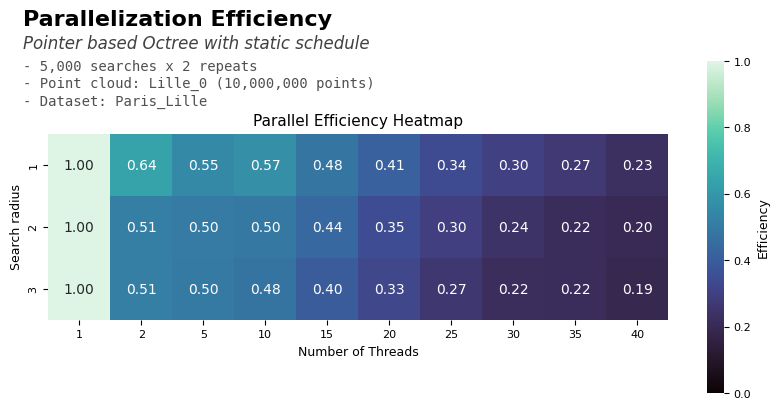

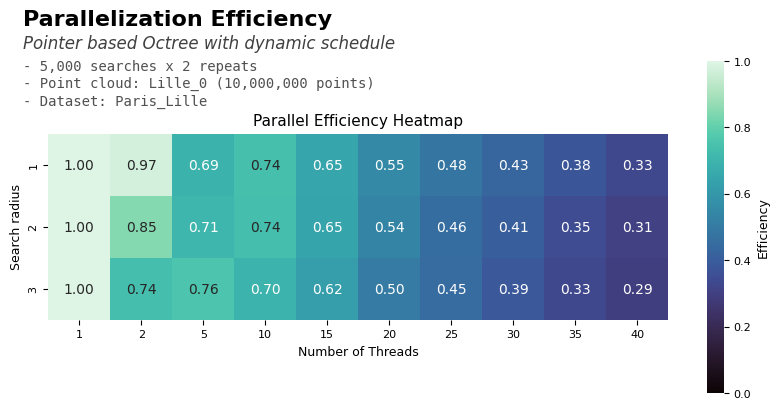

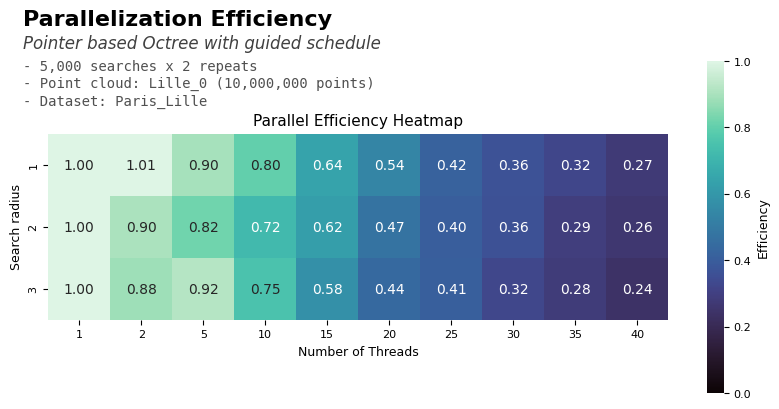

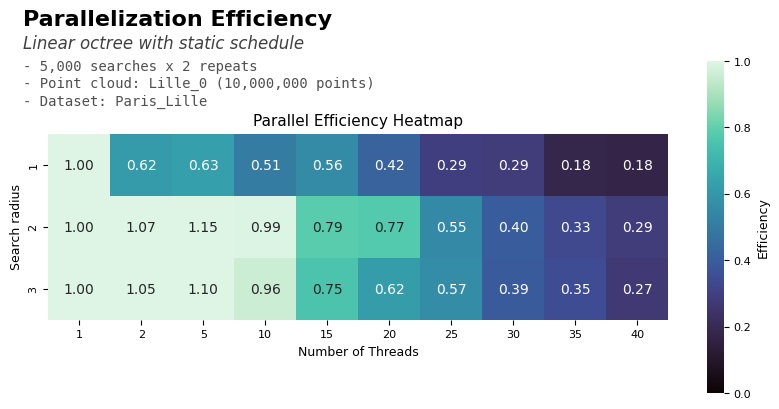

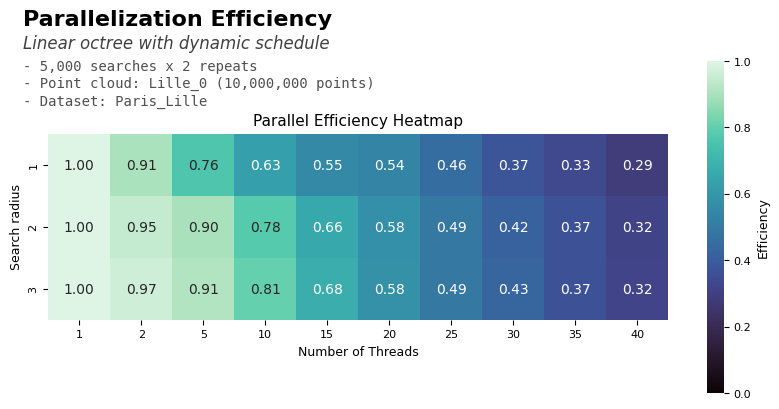

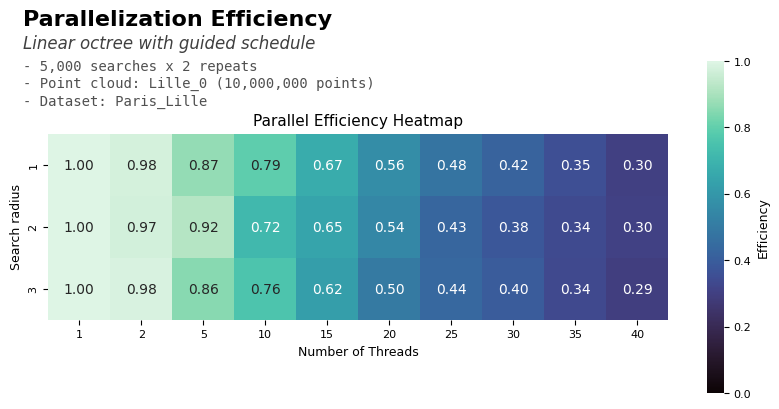

In [43]:
parallel_data_path = os.path.join(BASE_DATA_PATH, "parallel")

fig1 = octree_parallelization("Lille_0", "Paris_Lille", "static", "Octree", parallel_data_path)
fig2 = octree_parallelization("Lille_0", "Paris_Lille", "dynamic", "Octree", parallel_data_path)
fig3 = octree_parallelization("Lille_0", "Paris_Lille", "guided", "Octree", parallel_data_path)
fig4 = octree_parallelization("Lille_0", "Paris_Lille", "static", "LinearOctree", parallel_data_path)
fig5 = octree_parallelization("Lille_0", "Paris_Lille", "dynamic", "LinearOctree", parallel_data_path)
fig6 = octree_parallelization("Lille_0", "Paris_Lille", "guided", "LinearOctree", parallel_data_path)

In [ ]:
# Octree comparisons
assert(False)
for cloud, dataset in ALL_CLOUDS.items():
        for warmup in [False, True]:
            output_fig(octree_runtime_comparison(cloud, dataset, ['neighSearchStruct', 'neighSearch'], 'Neighbors search', warmup), "octree_comp_neigh", dataset, cloud)
            output_fig(octree_runtime_comparison(cloud, dataset, ['numNeighSearch'], 'Num. of neighbors search', warmup), "octree_comp_numneigh", dataset, cloud)

In [ ]:
# Point type comparisons
for cloud, dataset in ALL_CLOUDS.items():
    output_fig(octree_runtime_comparison(cloud, dataset, ['neighSearchStruct', 'neighSearch'], 'Num. of neighbors search', False,
                            TYPES_INFO_OCTREE_POINT, POINT_COMP_DATA_PATH), "point_comp_neigh", dataset, cloud)
    output_fig(octree_runtime_comparison(cloud, dataset, ['numNeighSearch'], 'Num. of neighbors search', False,
                            TYPES_INFO_OCTREE_POINT, POINT_COMP_DATA_PATH), "point_comp_numneigh", dataset, cloud)

In [ ]:
# Search impl. comparisons
for cloud, dataset in ALL_CLOUDS.items():
    output_fig(octree_operations_comparison(cloud, dataset, ['neighSearchStruct', 'neighSearch', 'neighOldSearch'], search_impl_palette), "impl_comp_neigh", dataset, cloud)
    output_fig(octree_operations_comparison(cloud, dataset, ['numNeighSearch', 'numNeighOldSearch'], num_search_impl_palette), "impl_comp_numneigh", dataset, cloud)

In [ ]:
# Approximate searches
for cloud, dataset in ALL_CLOUDS.items():
    for kernel in ["Sphere", "Cube"]:
        output_fig(approximate_search_comparison(cloud, dataset, kernel), f"approx_searches_{kernel.lower()}", dataset, cloud)

In [ ]:
# Multiple dataframes comparisons
# Could also output the regular ones but I think its enough with the speedup ones
for kernel in ["Sphere", "Cube"]:
    output_fig(multiple_dfs_speedups(CLOUDS_DATASETS, kernel, RADII, operations=['neighSearchStruct','neighSearch'], operation_name='Neighbors Search'), 
                f"speedup_neigh_search_{kernel.lower()}")
    output_fig(multiple_dfs_speedups(CLOUDS_DATASETS, kernel, RADII, operations=['numNeighSearch'], operation_name='Num. of Neighbors Search'), 
                f"speedup_num_neigh_search_{kernel.lower()}")

for kernel in ["Sphere", "Cube"]:
    output_fig(multiple_dfs_speedups(CLOUDS_DATASETS_HIGH_DENSITY, kernel, RADII_HIGH_DENSITY, operations=['neighSearchStruct','neighSearch'], operation_name='Neighbors Search'), 
                f"speedup_high_density_neigh_{kernel.lower()}")
    output_fig(multiple_dfs_speedups(CLOUDS_DATASETS_HIGH_DENSITY, kernel, RADII_HIGH_DENSITY, operations=['numNeighSearch'], operation_name='Num. of Neighbors Search'), 
                f"speedup_high_density_numneigh_{kernel.lower()}")

In [ ]:
# Avg result sizes vs runtime
for kernel in ["Sphere", "Cube"]:
    output_fig(plot_avg_result_sizes_log(ALL_CLOUDS, kernel, ["neighSearchStruct", "neighSearch"], "Neighbors search"),
               f"avg_result_size_runtime_neigh_{kernel.lower()}")
    output_fig(plot_avg_result_sizes_log(ALL_CLOUDS, kernel, ["numNeighSearch"], "Num. of Neighbors Search"),
               f"avg_result_size_runtime_numneigh_{kernel.lower()}")